# Libraries 

In [77]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder


# Load DatA Set

In [78]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    print(data.head())
    return data

# Classyfy columns 

In [79]:
def classify_columns(data_frame):
    categorical_columns = data_frame.select_dtypes(include=['object']).columns
    numeric_columns = data_frame.select_dtypes(include=['int64', 'float64']).columns
    return list(categorical_columns), list(numeric_columns)

# Preprocessing 

In [80]:
def preprocess_target_variable(data_frame, target_variable):
    encoder = LabelEncoder()
    data_frame[target_variable] = encoder.fit_transform(data_frame[target_variable])
    return data_frame

def preprocess_categorical_data(data_frame, column_name):
    if column_name != 'species':
        imputer = SimpleImputer(strategy='most_frequent')
        transformed_values = imputer.fit_transform(data_frame[[column_name]])
        data_frame[column_name] = transformed_values[:, 0]
        encoder = OneHotEncoder(handle_unknown='ignore')
        encoded_data = encoder.fit_transform(data_frame[[column_name]])
        encoded_df = pd.DataFrame(encoded_data.toarray(), columns=[f"{column_name}_{category}" for category in encoder.categories_[0]])
        data_frame = pd.concat([data_frame, encoded_df], axis=1)
        data_frame.drop(column_name, axis=1, inplace=True)
    return data_frame

def preprocess_numeric_data(data_frame, column_name):
    if column_name != 'species':
        imputer = SimpleImputer(strategy='median')
        data_frame[column_name] = imputer.fit_transform(data_frame[[column_name]])
        scaler = StandardScaler()
        data_frame[column_name] = scaler.fit_transform(data_frame[[column_name]])
    return data_frame


# Remove Outliers 

In [82]:
def remove_numeric_outliers(df, multiplier=1.5):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for column in numeric_columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - multiplier * iqr
        upper_bound = q3 + multiplier * iqr
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Feature selection 

In [83]:
def feature_selection(dataset, target_variable, k=5):
    if target_variable not in dataset.columns:
        raise ValueError(f"Target variable '{target_variable}' not found in the dataset columns.")
    
    X = dataset.drop(target_variable, axis=1)
    y = dataset[target_variable]
    if not pd.api.types.is_categorical_dtype(y):
        y = pd.Categorical(y).codes
    k_best = SelectKBest(score_func=f_classif, k=min(k, len(X.columns)))  # Use min(k, num_features) to avoid errors
    X_selected = k_best.fit_transform(X, y)
    selected_feature_indices = k_best.get_support(indices=True)
    selected_columns = X.columns[selected_feature_indices]

    selected_dataset = dataset[selected_columns]
    
    return selected_dataset, dataset[target_variable]


# Model Selection 

In [84]:
def train_and_evaluate_models(X_train, y_train, X_test, y_test, target_variable):
    if target_variable == 'species':
        logistic_regression_model = LogisticRegression(random_state=42)
        random_forest_model = RandomForestClassifier(random_state=42)
        xgboost_model = XGBClassifier(random_state=42)
        logistic_regression_model.fit(X_train, y_train)
        random_forest_model.fit(X_train, y_train)
        xgboost_model.fit(X_train, y_train)
        logistic_regression_predictions = logistic_regression_model.predict(X_test)
        random_forest_predictions = random_forest_model.predict(X_test)
        xgboost_predictions = xgboost_model.predict(X_test)
        logistic_regression_accuracy = accuracy_score(y_test, logistic_regression_predictions)
        random_forest_accuracy = accuracy_score(y_test, random_forest_predictions)
        xgboost_accuracy = accuracy_score(y_test, xgboost_predictions)

        print("Logistic Regression Accuracy:", logistic_regression_accuracy)
        print("Random Forest Accuracy:", random_forest_accuracy)
        print("XGBoost Accuracy:", xgboost_accuracy)

        # Output the best model
        best_model = max([
            ('Logistic Regression', logistic_regression_accuracy*100),
            ('Random Forest', random_forest_accuracy*100),
            ('XGBoost', xgboost_accuracy*100)
        ], key=lambda x: x[1])

        print(f"\nBest Model: {best_model[0]} with Accuracy: {best_model[1]}")

        return best_model[0], best_model[1]

    else:
        raise ValueError("Invalid target variable name")


# Best MOdel 

In [85]:
def train_best_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    print(f"Model: {type(model).__name__}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    
    return accuracy

# PLots 

In [86]:
def plot_box_plots(data):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data)
    plt.title("Box Plot For Checking   Outliers")
    plt.xticks(rotation=45)
    plt.show()

def plot_histograms(X):
    X.hist()
    plt.suptitle('Histograms of Features')
    plt.show()

# Main

   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa


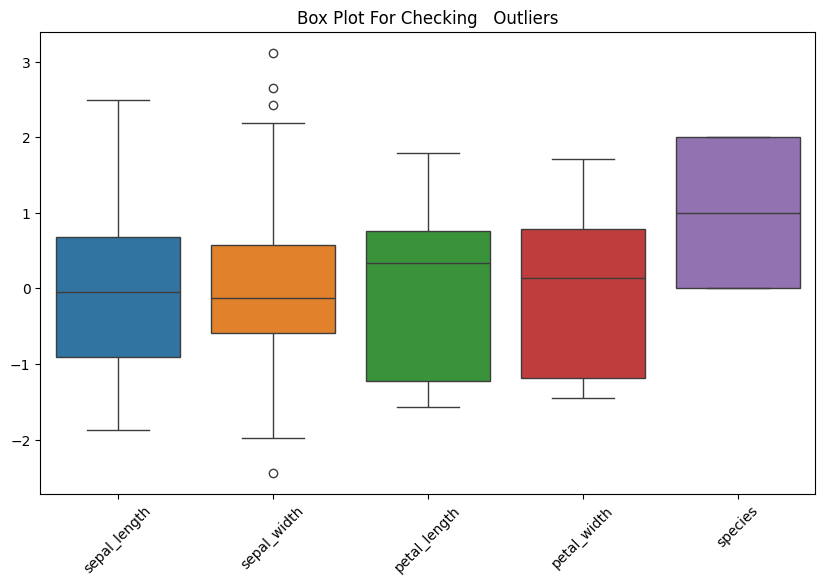

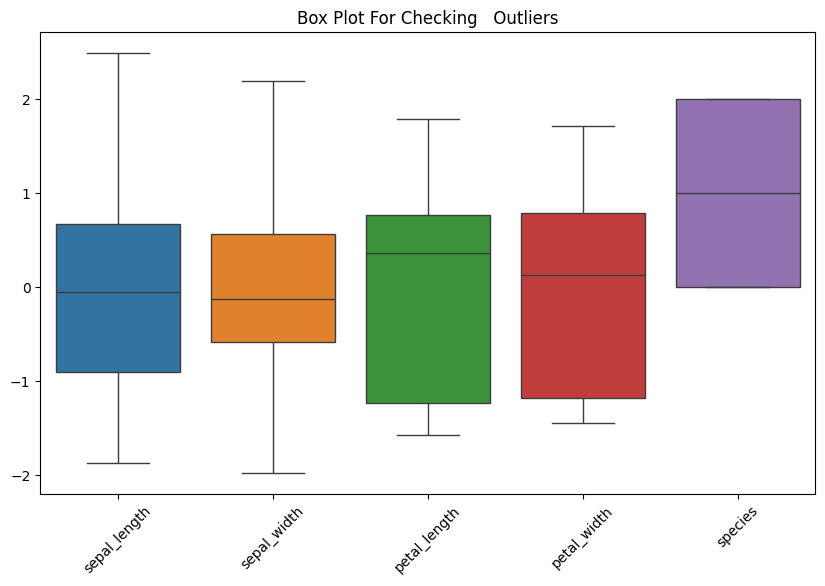

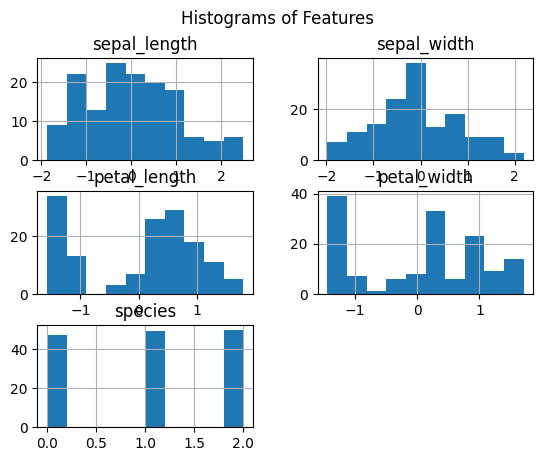



 Data Fter preprocessing


   sepal_length  sepal_width  petal_length  petal_width  species
0     -0.900681     1.032057     -1.341272    -1.312977        0
1     -1.143017    -0.124958     -1.341272    -1.312977        0
2     -1.385353     0.337848     -1.398138    -1.312977        0
3     -1.506521     0.106445     -1.284407    -1.312977        0
4     -1.021849     1.263460     -1.341272    -1.312977        0


 Chose best model 


C:\Users\mahma\AppData\Local\Temp\ipykernel_14380\2524128459.py:7: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(y):


Logistic Regression Accuracy: 0.9333333333333333
Random Forest Accuracy: 0.9333333333333333
XGBoost Accuracy: 0.9333333333333333

Best Model: Logistic Regression with Accuracy: 93.33333333333333

Training the Best Model:

Evaluating the Best Model:
Model: LogisticRegression
Accuracy: 0.9333333333333333
Precision: 0.9333333333333333
Recall: 0.9333333333333333
F1 Score: 0.9333333333333333
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.88      0.88      0.88         8
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.92      0.92      0.92        30
weighted avg       0.93      0.93      0.93        30

Accuracy: 0.9333333333333333


In [87]:
def main():
    file_path = "IRIS.csv"  
    data = load_data(file_path)
    data = preprocess_target_variable(data, 'species')
    categorical_columns, numeric_columns = classify_columns(data)
    for column in categorical_columns:
        data = preprocess_categorical_data(data, column)
    for column in numeric_columns:
        data = preprocess_numeric_data(data, column)
    plot_box_plots(data)
    data = remove_numeric_outliers(data)
    plot_box_plots(data)
    plot_histograms(data)
    print("\n\n Data AFter preprocessing\n\n")
    print(data.head())
    try:
        selected_features, target_variable = feature_selection(data, 'species', k=5)
    except ValueError as e:
        print(e)
        return
    X_train, X_test, y_train, y_test = train_test_split(selected_features, data['species'], test_size=0.2, random_state=42)
    print("\n\n Chose best model ")
    best_model, best_accuracy = train_and_evaluate_models(X_train, y_train, X_test, y_test, 'species')
    print("\nTraining the Best Model:")
    if best_model == 'Logistic Regression':
        model = LogisticRegression(random_state=42)
    elif best_model == 'Random Forest':
        model = RandomForestClassifier(random_state=42)
    elif best_model == 'XGBoost':
        model = XGBClassifier(random_state=42)
    else:
        raise ValueError("Invalid best model")

    model.fit(X_train, y_train)
    print("\nEvaluating the Best Model:")
    accuracy = train_best_model(X_train, y_train, X_test, y_test, model)
    print(f"Accuracy: {accuracy}")


if __name__ == "__main__":
    main()
